# Practice Session 06: PageRank

<font size="+2" color="blue">Additional results: spam/nonspam visualization</font>

# 1. Read host names

In [2]:
import io
import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
INPUT_NODES_FILENAME = "webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "webspam_uk2007-edges.csv.gz"
OUTPUT_EXTRA_NODES_FILENAME = "webspam_uk2007extra-nodes.csv"
OUTPUT_EXTRA_EDGES_FILENAME = "webspam_uk2007extra-edges.csv"

In [5]:
with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as input_file:
  name2id = {}
  id2name = {}
  id2label = {}
  reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
  for record in reader:
    key = int(record["nodeid"]) #la key del diccionario corresponde al id de cada nodo
    key2 = record["hostname"] #la key del diccionario name2id será el nombre de cada nodo
    id2name[key] = key2 #id2name contendrá los hostnames como valores
    id2label[key] = record["label"] #id2label contendrá los labels como valores
    name2id[key2] = key #name2id contendrá los ids como valores

In [6]:
# Leave as-is

print("%s: %s" % (id2name[873], id2label[873]))
print("%s: %s" % (id2name[105715], id2label[105715]))
print("Number of hosts: %s" % len(id2name))

bbc.co.uk: nonspam
www.top-mobile-phones.co.uk: spam
Number of hosts: 114529


In [7]:
spam = 0
nonspam = 0
for host in id2label:
  if id2label[host] == "spam":
    spam+=1
  elif id2label[host] == "nonspam":
    nonspam+=1
print("Number of spam hosts: %s" % spam)
print("Number of nonspam hosts: %s" % nonspam)
print("Number of unlabeled hosts: %s" % (len(id2label)-(spam+nonspam))) #si el label del nodo no es spam ni nonspam entonces deberá ser unlabeled

Number of spam hosts: 344
Number of nonspam hosts: 5709
Number of unlabeled hosts: 108476


In [8]:
spammywords = ['escort', 'xx', 'girl', 'credit', 'mortgage', 'finance', 'debt', 'loan']
g = nx.DiGraph()
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
  reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
  for record in reader:
    source = int(record["source"]) 
    destination = int(record["destination"])
    for word in spammywords:
      if word in id2name[source] or word in id2name[destination]: #comprobamos tanto si el el nodo de origen como el de destino contienen alguna de las spammywords
        if id2label[source] == "spam" or id2label[source] == "nonspam": #comprobamos que el nodo de origen no sea unlabeled
          if id2label[destination] == "spam" or id2label[destination] == "nonspam": #comprobamos que el nodo de destino no sea unlabeled
            if id2name[source] not in g: #nos aseguramos que el nodo npo exista en el grafo antes de crearlo. esto es innecesario ya que g.addnode ya evita duplicar nodos, pero partiendo de la premisa que desconocemos el contenido de g.addnode(), conseguimos que nuestro código sea más preciso
              g.add_node(id2name[source])
            if id2name[destination] not in g: #nos aseguramos de que el nodo de destino tampoco exista en el grafo
              g.add_node(id2name[destination])
            g.add_edge(id2name[source], id2name[destination]) #creamos el enlace entre ambos nodos
print(g.number_of_nodes())

57


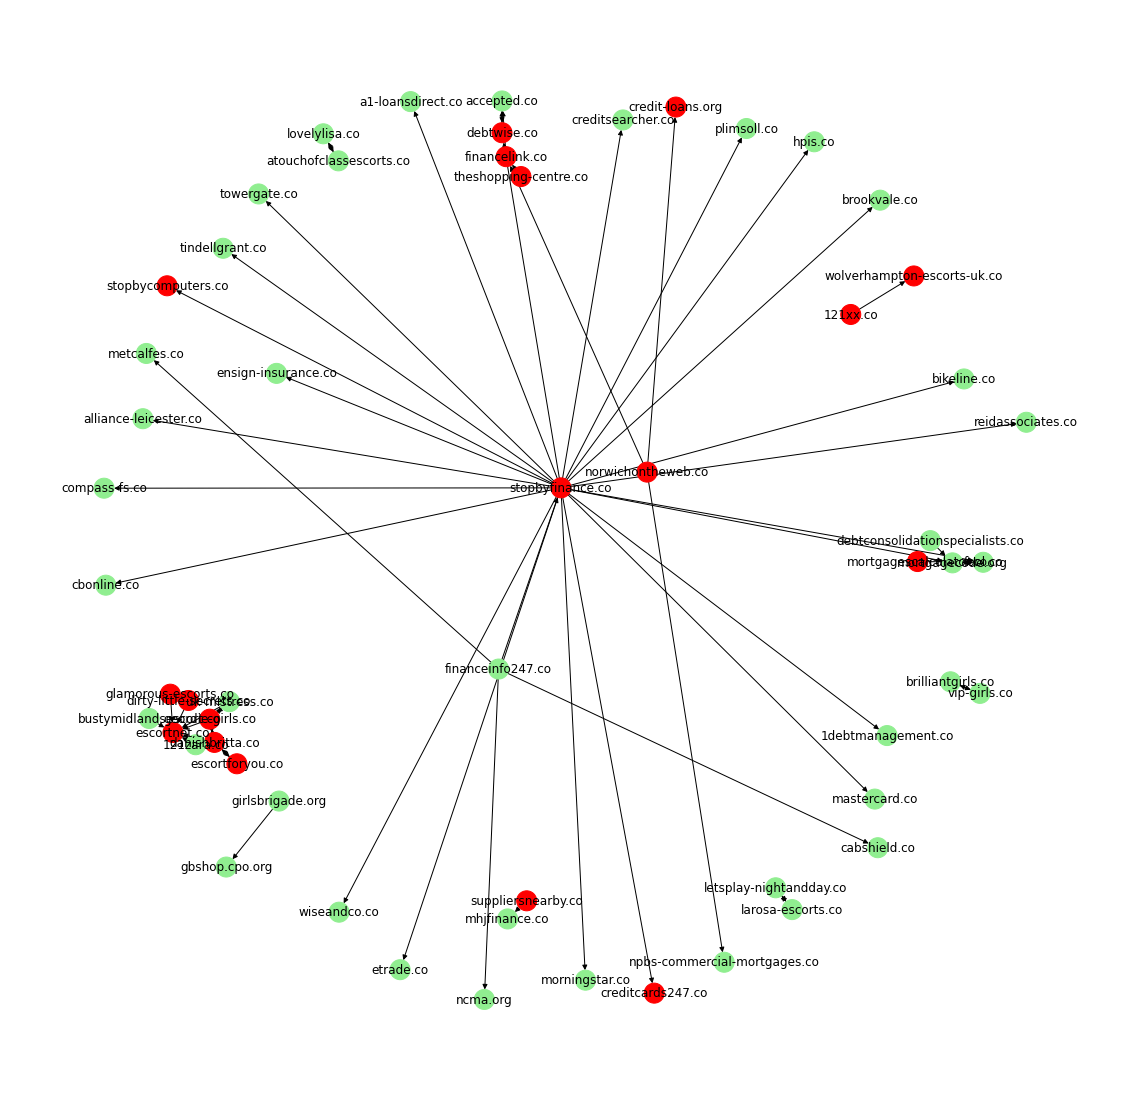

In [ ]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if id2label[name2id[hostname]] == 'spam':
        colors.append('red')
    elif id2label[name2id[hostname]] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')
    
    # Shorten the hostnames to generate labels    
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label
    
# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

<font size="+1" color="black">Este grafo muestra los enlaces que apuntan desde una página a otra, sean de spam o no, siempre que una de ellas contenga una de las. palabras relacionadas con spam. Podemos apreciar como la mayoría de páginas no son de spam, pero que a la vez éstas son las que tienen menor grado saliente, pues las páginas de spam son las que más enlaces suelen tener hacia otras páginas, ya sean páginas también de spam o no. Otro fenómeno que observamos es que, mientras las páginas de spam suelen tener enlaces de páginas que no son de spam, estas últimas raramente apuntat a páginas de spam, pues éstas suelen ser apuntadas por otras páginas de spam</font>

# 2. Compute the degree of each node

In [9]:
# Leave this code as-is

id2degree = {}
N = len(id2name)
for nodeid in range(N):
    id2degree[nodeid] = 0

In [10]:
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
  reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
  for record in reader:
    source = int(record["source"])
    id2degree[source]+=1 #para cada enlace incrementamos en 1 el grado del nodo de origen

In [11]:
# Leave this cell as-is

for nodeid in [890, 1469, 105715]:
    print("%s: degree %d" % (id2name[nodeid], id2degree[nodeid]))

bc1.org.uk: degree 16
candycaine.skinthesun.co.uk: degree 22
www.top-mobile-phones.co.uk: degree 0


# 3. Compute PageRank

In [14]:
# Leave this cell as-is

ITERATIONS = 20
ALPHA = 0.85

pagerank_aux = [0.0] * N
pagerank = [1.0/N] * N

In [15]:
for iteration in range(ITERATIONS):
    print("Iteration %d of %d" % (iteration+1, ITERATIONS))
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
      reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
      for record in reader:
        source = int(record["source"])
        destination = int(record["destination"])
        degree = id2degree[source]
        pagerank_aux[destination] += pagerank[source]/degree #para cada enlace añadimos al pagerank auxiliar del nodo de destino el valor del pagerank del nodo de origen devidido por el grado de salida del nodo de origen
    for i in range(N):
      pagerank[i] = ALPHA * pagerank_aux[i] + (1.0-ALPHA) * (1.0/N) #el pagerank de cada nodo será equivalente a esta fórmula, que ya tiene en cuenta todos los enlaces
      pagerank_aux[i] = 0.0 #inicializamos de nuevo el vector auxiliar a 0

Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20


# 4. Nodes with largest values of PageRank

In [17]:
pagerank_ordered = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)
for i in range(20):
  print("%d, %s, %s: %f " % (pagerank_ordered[i][0], id2name[pagerank_ordered[i][0]], id2label[pagerank_ordered[i][0]], round(pagerank_ordered[i][1],6)))

81634, www.opsi.gov.uk, unlabeled: 0.001517 
10990, www.adobe.co.uk, unlabeled: 0.001418 
60715, www.ico.gov.uk, unlabeled: 0.000965 
42757, www.dti.gov.uk, unlabeled: 0.000896 
39774, www.defra.gov.uk, unlabeled: 0.000894 
5169, news.bbc.co.uk, unlabeled: 0.000780 
40999, www.direct.gov.uk, unlabeled: 0.000721 
40559, www.dfes.gov.uk, unlabeled: 0.000698 
51107, www.fsa.gov.uk, unlabeled: 0.000682 
77619, www.nationalrail.co.uk, unlabeled: 0.000658 
34406, www.communities.gov.uk, unlabeled: 0.000655 
19504, www.bbc.co.uk, unlabeled: 0.000648 
54071, www.google.co.uk, unlabeled: 0.000603 
40612, www.dh.gov.uk, unlabeled: 0.000591 
58631, www.hmso.gov.uk, unlabeled: 0.000582 
59870, www.hse.gov.uk, unlabeled: 0.000576 
48290, www.fco.gov.uk, unlabeled: 0.000540 
77627, www.nationaltrust.org.uk, nonspam: 0.000516 
59140, www.homeoffice.gov.uk, unlabeled: 0.000484 
5056, mysite.wanadoo-members.co.uk, nonspam: 0.000458 


<font size="+1" color="black">Replace this cell with a brief commentary indicating: (1) why do you think the top site is that one, and (2) what is the percentage of commercial, government, and educational sites you see among the top 20?
La página con mayor pagerank es www.opsi.gov.uk, una página destinada a la legislación del gobierno, por lo cual tiene sentido que sea la primera, puesto que un gran número de páginas web de todo UK apuntan a páginas del gobierno, ya sea porque son páginas de empresas, organizaciones o instituciones públicas que colaboran o dependen del gobierno o bien porque se trate de cualquier página cuyo contenido contenga información de eventos oa ctividades que dependen de la legislación gubernamental.
Un 30% de estas 20 páginas son comerciales, mientras un 65% son gubernamentales y el 5% restante son educativas.</font>

# 5. Run non-spam PageRank

In [19]:
id2nsdegree = {}
for nodeid in range(N):
  id2nsdegree[nodeid] = 0
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
  reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
  for record in reader:
    source = int(record["source"])
    destination = int(record["destination"])
    if id2label[source] != "spam" and id2label[destination] != "spam": #a diferencia del caso anterior, aquí debemos comprobar que ni el nodo de origen ni el de destino sean spam
      id2nsdegree[source]+=1

In [20]:
# Leave this cell as-is

for nodeid in [890, 1469, 105715]:
    print("%s: normal degree %d nospam degree %d" % (id2name[nodeid], id2degree[nodeid], id2nsdegree[nodeid]))

bc1.org.uk: normal degree 16 nospam degree 16
candycaine.skinthesun.co.uk: normal degree 22 nospam degree 20
www.top-mobile-phones.co.uk: normal degree 0 nospam degree 0


In [21]:
pagerank_aux = [0.0] * N
nspagerank = [1.0/N] * N

for iteration in range(ITERATIONS):
    print("Iteration %d of %d" % (iteration+1, ITERATIONS))
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
      reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
      for record in reader:
        source = int(record["source"])
        destination = int(record["destination"])
        degree = id2nsdegree[source] #el grado esta vez es el nospam degree
        if id2label[source] != "spam" and id2label[destination] != "spam": #igual que con el nsdegree, a diferencia del pagerank normal, nos aseguramos que ninguno de los nodos sea spam
           pagerank_aux[destination] += nspagerank[source]/degree
    for i in range(N):
      nspagerank[i] = ALPHA * pagerank_aux[i] + (1.0-ALPHA) * (1.0/N)
      pagerank_aux[i] = 0.0

Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20


In [22]:
nspagerank_ordered = sorted(enumerate(nspagerank), key=lambda x: x[1], reverse=True)
for i in range(20):
  print("%d, %s, %s: %f " % (nspagerank_ordered[i][0], id2name[nspagerank_ordered[i][0]], id2label[nspagerank_ordered[i][0]], round(nspagerank_ordered[i][1],6)))

81634, www.opsi.gov.uk, unlabeled: 0.001516 
10990, www.adobe.co.uk, unlabeled: 0.001418 
60715, www.ico.gov.uk, unlabeled: 0.000964 
42757, www.dti.gov.uk, unlabeled: 0.000895 
39774, www.defra.gov.uk, unlabeled: 0.000893 
5169, news.bbc.co.uk, unlabeled: 0.000780 
40999, www.direct.gov.uk, unlabeled: 0.000720 
40559, www.dfes.gov.uk, unlabeled: 0.000698 
51107, www.fsa.gov.uk, unlabeled: 0.000680 
77619, www.nationalrail.co.uk, unlabeled: 0.000657 
34406, www.communities.gov.uk, unlabeled: 0.000655 
19504, www.bbc.co.uk, unlabeled: 0.000648 
54071, www.google.co.uk, unlabeled: 0.000602 
40612, www.dh.gov.uk, unlabeled: 0.000591 
58631, www.hmso.gov.uk, unlabeled: 0.000582 
59870, www.hse.gov.uk, unlabeled: 0.000575 
48290, www.fco.gov.uk, unlabeled: 0.000539 
77627, www.nationaltrust.org.uk, nonspam: 0.000515 
59140, www.homeoffice.gov.uk, unlabeled: 0.000483 
5056, mysite.wanadoo-members.co.uk, nonspam: 0.000458 


# 6. Compute spam gain

In [23]:
spamgain = [0.0] * N
for i in range(N):
  spamgain[i] = pagerank[i] / nspagerank[i]  #el gain de cada nodo equivale a su pagerank total dividido por su nospam pagerank
spamgain_ordered = sorted(enumerate(spamgain), key=lambda x: x[1], reverse=True)
for i in range(50):
  print("%s, %s, gain: %s (pagerank: %.2g, nospampagerank: %.2g) " % (id2name[spamgain_ordered[i][0]], id2label[spamgain_ordered[i][0]], round(spamgain_ordered[i][1],2), pagerank[spamgain_ordered[i][0]], nspagerank[spamgain_ordered[i][0]]))

www.escortnet.co.uk, spam, gain: 33.14 (pagerank: 4.3e-05, nospampagerank: 1.3e-06) 
www.missionfish.org.uk, spam, gain: 29.06 (pagerank: 3.8e-05, nospampagerank: 1.3e-06) 
www.statistics.006.free-counter.co.uk, spam, gain: 17.9 (pagerank: 2.3e-05, nospampagerank: 1.3e-06) 
www.uk-shoponline.co.uk, spam, gain: 13.64 (pagerank: 1.8e-05, nospampagerank: 1.3e-06) 
www.shop.co.uk, spam, gain: 10.8 (pagerank: 1.4e-05, nospampagerank: 1.3e-06) 
www.geordie-girls.co.uk, spam, gain: 10.42 (pagerank: 1.4e-05, nospampagerank: 1.3e-06) 
www.into.demon.co.uk, spam, gain: 10.35 (pagerank: 1.4e-05, nospampagerank: 1.3e-06) 
www.computerarts.co.uk, spam, gain: 10.07 (pagerank: 1.3e-05, nospampagerank: 1.3e-06) 
www.aili.co.uk, unlabeled, gain: 9.32 (pagerank: 1.3e-05, nospampagerank: 1.4e-06) 
connect4fun.co.uk, spam, gain: 8.87 (pagerank: 1.2e-05, nospampagerank: 1.3e-06) 
www.kompass.co.uk, spam, gain: 8.45 (pagerank: 1.1e-05, nospampagerank: 1.3e-06) 
www.mercurywd.co.uk, spam, gain: 8.0 (pagerank

<font size="+1" color="black">
Las páginas anteriores son las 50 con mayor ganancia de spam, o spamgain, lo cual se refiere a la relación de pagerank con el nonspampagerank. Esto significa que las páginas con mayor gain contendrán un pagerank elevado de spam, es decir, habrán más paginas de spam que las apunten que otras páginas. Es por esto que se aprecia que prácticamente todas las 50 páginas con mayor gain son de tipo spam, lo cual es entendible ya que a las páginas de spam les suelen apuntar más páginas de spam que de otro tipo.

Se puede apreciar como todas las páginas que son de spam tienen el mismo nspagerank. Esto es debido a que como son páginas de spam no tienen ningun nsdegree, ya que éste no contempla las páginas de spam, y que por tanto el pagerank de cada una equivale a (1-ALPHA)/N. </font>

In [24]:
nodes = [] #creamos un vector auxiliar para almacenar los nodos elegidos y poder discriminar los otros al escribir el csv de las interacciones
with io.open(OUTPUT_EXTRA_NODES_FILENAME, "w") as output_file: #abrimos el archivo en que vamos a escribir la información
  writer = csv.writer(output_file, delimiter='\t', quotechar='"') 
  writer.writerow(["Id", "Name", "Label","Pagerank","Nospam-pagerank","Gain"]) #escribimos los nombres de las columnas
  for i in range(10000): #establecemos el valor arbitráreo de 1000 iteraciones para que se generen aproximadamente unos 500 nodos
    id = pagerank_ordered[i][0] #el primer valor del vector ordenado corresponde al id de cada nodo y los seleccionamos en función de su valor pagerank en orden descendente, para seleccionar los más altos
    if id2label[id] != 'unlabeled': #discriminamos todos los nodos unlabeled
      name = id2name[id]
      label = id2label[id]
      pagerankvalue = pagerank_ordered[i][1] #el segundo valor del vector correspondía al valor del pagerank de cada nodo
      nspagerankvalue = nspagerank[id]
      gain = spamgain[id]
      writer.writerow([id, name, label, pagerankvalue, nspagerankvalue, gain]) #escribimos la fila con todos los atributos del nodo
      nodes.append(id) #añadimos el nodo al vector creado

In [25]:
with io.open(OUTPUT_EXTRA_EDGES_FILENAME, "w") as output_file:
    writer = csv.writer(output_file, delimiter='\t', quotechar='"')
    writer.writerow(["Source", "Destination", "Weight"])
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file: #leemos el archivo de entrada que contiene la información de los enlaces
      reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
      for record in reader:
        source = int(record["source"])
        destination = int(record["destination"])
        weight = record["weight"]
        if source in nodes and destination in nodes: #discriminamos todos los enlaces en que uno de los nodos no se encuentra en los 500 nodos seleccionados
          writer.writerow([source, destination, weight]) #escribimos la fila con los id de los nodos de origen y destino y el weight de dicha interacción

![spam/nonspam visualization](https://drive.google.com/uc?export=view&id=1ApzLbRPew2YxtvAGCmjywAHVJvkfOyiv)

Para generar este grafo primero hemos tenido que escribir el código para generar dos archivos csv, el primero sobre todos los nodos y sus atributos y el segundo sobre las interacciones. En el primer fragmento de código iteramos 10000 veces, el cual es un número arbitráreo para contar con aproximadamente 500 nodos, en las que vamos comprobando los nodos con mayor pagerank, en orden descendente, de esta forma seleccioanremos los nodos con mayor pagerank, y si éstos no tienen 'unlabeled' como label, escribimos una línea en el csv de salida con sus atributos id, name, label, pagerank, nspagerank y gain, estos dos últimos innecesarios pero los añadimos igualmente para que el grafo contenga toda la información de que disponemos. Paralelamente a esto hemos creado una lista en la que hemos ido introduciendo todos los nodos añadidos al csv.

En el segundo fragmento leemos el archivo de entrada que contiene todos los edges y para cada uno de ellos comprobamos que tanto el source como el destination se encuentren en la lista nodes, que contiene todos los nodos incluídos en el anterior csv, y si es así escribimos la línea con los ids del source y del destination y el weight.

Finalmente se aprecia la imagen del grafo que cuenta con unos 500 nodos aproximadamente y que contiene todos los enlaces dirigidos refereidos a que una página tiene algún enlace dirigido a la otra, y el grosor de cuyos enlaces corresponde al weight de los mismos, mientras que el tamaño de los nodos corresponde al pagerank de cada página y el color a si es de spam o no, tal y como muestra la leyenda.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>